<a href="https://www.kaggle.com/code/sharanharsoor/genai-rlhf-summarize-text-like-chatgpt?scriptVersionId=139165085" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# large language models (FLAN-T5)
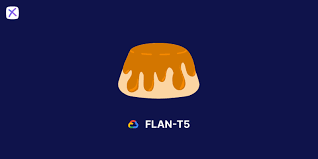<br>

flan-t5-small represents a significant advancement in Large Language Models (LLMs), serving as a foundational and versatile base model. Unlike task-specific models, it can be fine-tuned to suit specific language processing tasks, offering users the flexibility to customize it for various applications and objectives. <br>

FLAN-T5 model is a encoder-decoder model that has been pre-trained on a multi-task mixture of unsupervised and supervised tasks and for which each task is converted into a text-to-text format.

During the training phase, FLAN-T5 was fed a large corpus of text data and was trained to predict missing words in an input text via a fill in the blank style objective. This process is repeated multiple times until the model has learned to generate text that is similar to the input data.

Once trained, FLAN-T5 can be used to perform a variety of NLP tasks, such as text generation, language translation, sentiment analysis, and text classification. <br>


# DeepLearning.AI
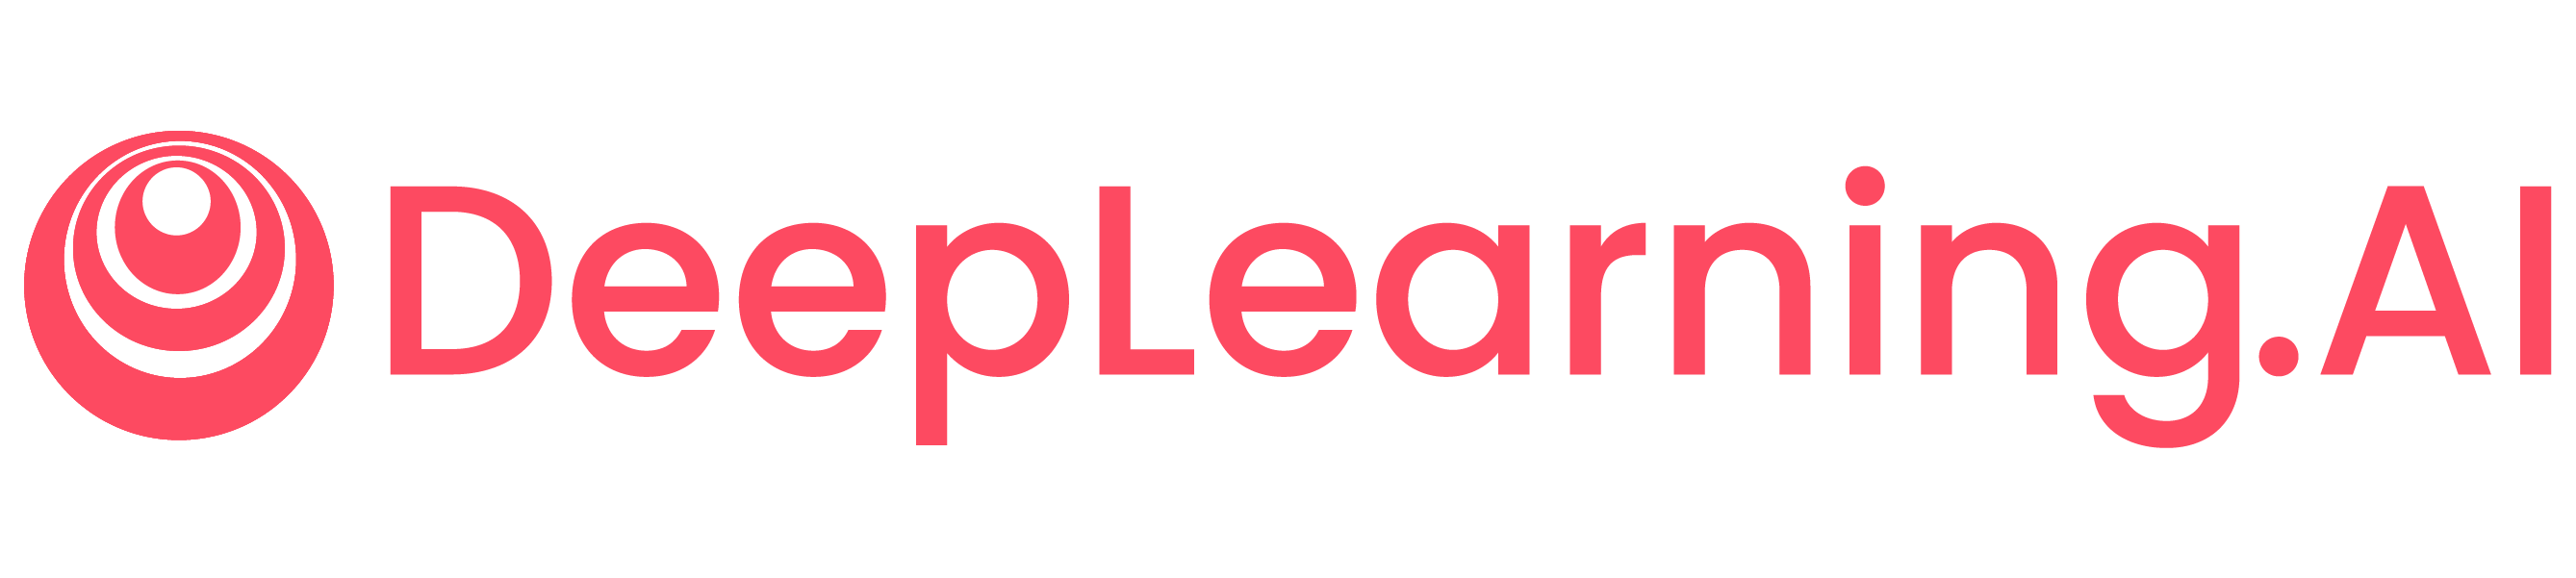<br>

<br>
The knowledge imparted in this notebook draws from the course "Generative AI with Large Language Models," provided by DeepLearning.AI on [Coursera](https://www.coursera.org/learn/generative-ai-with-llms/). This course stands out as an excellent foundation, covering LLMs from fundamental concepts to highly advanced topics. <br>

For those interested in exploring LLMs, I wholeheartedly recommend taking up this course. It offers comprehensive learning experiences and insights. While the original course employed the FLAN-T5-base model, our focus in this notebook will be on utilizing the FLAN-T5-small to delve into similar concepts.

# Hugging face <br>
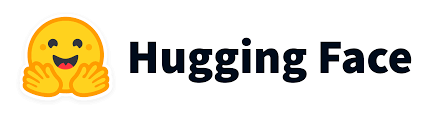<br>


This notebook guides you through the process of fine-tuning an existing Large Language Model (LLM) from Hugging Face to enhance dialogue summarization. The chosen model is [flan-t5-small](https://huggingface.co/google/flan-t5-small), which comes pre-tuned and capable of summarizing text with high quality "out of the box." To further enhance inferences, we will explore a full fine-tuning approach and assess the results using ROUGE metrics.

Additionally, we will perform Parameter Efficient Fine-Tuning (PEFT) to evaluate the resulting model and observe the advantages of PEFT, despite the slightly-lower performance metrics. This notebook offers valuable insights into optimizing dialogue summarization using the flan-t5-small model and fine-tuning techniques for improved outcomes.

# 1- Set up Kernel, Load Required Dependencies, Dataset and LLM

In [1]:
%pip install --upgrade pip
%pip install --disable-pip-version-check \
    torch==1.13.1 \
    torchdata==0.5.1 --quiet

%pip install \
    transformers==4.27.2 \
    datasets==2.11.0 \
    evaluate==0.4.0 \
    rouge_score==0.1.2 \
    loralib==0.1.1 \
    peft==0.3.0 --quiet

%pip install -q einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Import libs

In [2]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer,AutoModelForSequenceClassification, GenerationConfig, TrainingArguments, Trainer,AutoModelForCausalLM
import torch
import time
import evaluate
import pandas as pd
import numpy as np

from tqdm import tqdm
tqdm.pandas()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## Load Dataset and LLM <br>
we will be using the [DialogSum](https://huggingface.co/datasets/knkarthick/dialogsum) Hugging Face dataset. It contains 10,000+ dialogues with the corresponding manually labeled summaries and topics.<br>
<br>
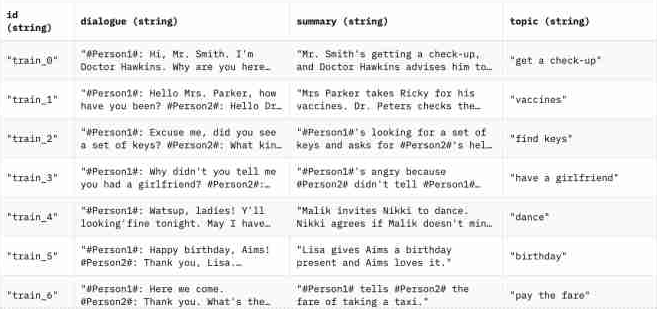<br>

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
huggingface_dataset_name = "knkarthick/dialogsum"
dataset = load_dataset(huggingface_dataset_name)
dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/knkarthick___csv/knkarthick--dialogsum-c8fac5d84cd35861/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
})

## Load the pre-trained model.

In [5]:
model_name= "google/flan-t5-small"
original_model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype=torch.bfloat16, device_map='auto')
original_model.to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

In [6]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(original_model))

trainable model parameters: 76961152
all model parameters: 76961152
percentage of trainable model parameters: 100.00%


## Test the Model with Zero Shot Inferencing
Test the model with the zero shot inferencing. You can see that the model struggles to summarize the dialogue compared to the baseline summary, but it does pull out some important information from the text which indicates the model can be fine-tuned to the task at hand.

In [7]:
index = 200

dialogue = dataset['test'][index]['dialogue']
summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

{dialogue}

Summary:
"""

inputs = tokenizer(prompt, return_tensors='pt')
output = tokenizer.decode(
    original_model.generate(
        inputs["input_ids"], 
        max_new_tokens=200,
    )[0], 
    skip_special_tokens=True
)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1374: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Summarize the following conversation.

#Person1#: Have you considered upgrading your system?
#Person2#: Yes, but I'm not sure what exactly I would need.
#Person1#: You could consider adding a painting program to your software. It would allow you to make up your own flyers and banners for advertising.
#Person2#: That would be a definite bonus.
#Person1#: You might also want to upgrade your hardware because it is pretty outdated now.
#Person2#: How can we do that?
#Person1#: You'd probably need a faster processor, to begin with. And you also need a more powerful hard disc, more memory and a faster modem. Do you have a CD-ROM drive?
#Person2#: No.
#Person1#: Then you might want to add a CD-ROM drive too, because most new software programs are coming out on Cds.
#Person2#: That sounds great. Thanks.

Summary:

-------------------------------------------------------------------

# 2 - Perform Full Fine-Tuning

## Preprocess the Dialog-Summary Dataset

Need to convert the dialog-summary (prompt-response) pairs into explicit instructions for the LLM. Prepend an instruction to the start of the dialog with Summarize the following conversation and to the start of the summary with Summary as follows:

Training prompt (dialogue):

Summarize the following conversation.

    Chris: This is his part of the conversation.
    Antje: This is her part of the conversation.
    
Summary: 
Training response (summary):

Both Chris and Antje participated in the conversation.
Then preprocess the prompt-response dataset into tokens and pull out their input_ids (1 per token)

In [8]:
def tokenize_function(example):
    start_prompt = 'Summarize the following conversation.\n\n'
    end_prompt = '\n\nSummary: '
    prompt = [start_prompt + dialogue + end_prompt for dialogue in example["dialogue"]]
    example['input_ids'] = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt").input_ids
    example['labels'] = tokenizer(example["summary"], padding="max_length", truncation=True, return_tensors="pt").input_ids
    
    return example

# The dataset actually contains 3 diff splits: train, validation, test.
# The tokenize_function code is handling all data across all splits in batches.
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['id', 'topic', 'dialogue', 'summary',])

Map:   0%|          | 0/12460 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [9]:
tokenized_datasets = tokenized_datasets.filter(lambda example, index: index % 100 == 0, with_indices=True)

Filter:   0%|          | 0/12460 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

In [10]:
print(f"Shapes of the datasets:")
print(f"Training: {tokenized_datasets['train'].shape}")
print(f"Validation: {tokenized_datasets['validation'].shape}")
print(f"Test: {tokenized_datasets['test'].shape}")

print(tokenized_datasets)

Shapes of the datasets:
Training: (125, 2)
Validation: (5, 2)
Test: (15, 2)
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 125
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 15
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 5
    })
})


The output dataset is ready for fine-tuning.

## Fine-Tune the Model with the Preprocessed Dataset

Now utilize the built-in Hugging Face `Trainer` class (see the documentation [here](https://huggingface.co/docs/transformers/main_classes/trainer)). Pass the preprocessed dataset with reference to the original model. Other training parameters are found experimentally and there is no need to go into details about those at the moment.

In [11]:
output_dir = f'./dialogue-summary-training-epoch1'

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=1e-5,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_steps=1,
    max_steps=5
)

trainer = Trainer(
    model=original_model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation']
)

In [12]:
import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("WANDB")
    wandb.login(key=api_key)
    anonymous = None
except:
    wandb.login(anonymous='must')
    print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


To use your W&B account,
Go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. 
Get your W&B access token from here: https://wandb.ai/authorize


In [13]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Currently logged in as: anony-moose-604389058728526964. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.15.8 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.5
wandb: Run data is saved locally in /kaggle/working/wandb/run-20230807_095501-wm75ccmx
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run valiant-capybara-1
wandb: ⭐️ View project at https://wandb.ai/anony-moose-604389058728526964/huggingface?apiKey=cf848da168747e291d5375011423c050e4e94c57
wandb: 🚀 View run at https://wandb.ai/anony-moose-604389058728526964/huggingface/runs/wm75ccmx?apiKey=cf848da168747e291d53750

Step,Training Loss
1,55.500000
2,59.250000
3,57.750000
4,60.750000
5,59.750000


TrainOutput(global_step=5, training_loss=58.6, metrics={'train_runtime': 33.3075, 'train_samples_per_second': 1.201, 'train_steps_per_second': 0.15, 'total_flos': 7435620188160.0, 'train_loss': 58.6, 'epoch': 0.31})

In [14]:
trainer.save_model(f'./out_fold_model')

In [15]:
! ls out_fold_model

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
config.json  generation_config.json  pytorch_model.bin	training_args.bin


In [16]:
instruct_model = AutoModelForSeq2SeqLM.from_pretrained("./out_fold_model", torch_dtype=torch.bfloat16,device_map='auto')
instruct_model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
              (wo): 

## Evaluate the Model Qualitatively (Human Evaluation)
As with many GenAI applications, a qualitative approach where you ask yourself the question "Is my model behaving the way it is supposed to?" is usually a good starting point. In the example below (the same one we started this notebook with), you can see how the fine-tuned model is able to create a reasonable summary of the dialogue compared to the original inability to understand what is being asked of the model.

In [17]:
index = 200
dialogue = dataset['test'][index]['dialogue']
human_baseline_summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

{dialogue}

Summary:
"""

input_ids = tokenizer(prompt, return_tensors="pt").input_ids
input_ids.to(device)

original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{human_baseline_summary}')
print(dash_line)
print(f'ORIGINAL MODEL:\n{original_model_text_output}')
print(dash_line)
print(f'INSTRUCT MODEL:\n{instruct_model_text_output}')

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.
---------------------------------------------------------------------------------------------------
ORIGINAL MODEL:
I'd like to make a video game.
---------------------------------------------------------------------------------------------------
INSTRUCT MODEL:
How would you like to upgrade your computer?


## Evaluate the Model Quantitatively (with ROUGE Metric)
The ROUGE metric helps quantify the validity of summarizations produced by models. It compares summarizations to a "baseline" summary which is usually created by a human. While not perfect, it does indicate the overall increase in summarization effectiveness that we have accomplished by fine-tuning.

In [18]:
rouge = evaluate.load('rouge')

In [19]:
dialogues = dataset['test'][0:10]['dialogue']
human_baseline_summaries = dataset['test'][0:10]['summary']

original_model_summaries = []
instruct_model_summaries = []

for _, dialogue in enumerate(dialogues):
    prompt = f"""
Summarize the following conversation.

{dialogue}

Summary: """
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids

    original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)
    original_model_summaries.append(original_model_text_output)

    instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)
    instruct_model_summaries.append(instruct_model_text_output)
    
zipped_summaries = list(zip(human_baseline_summaries, original_model_summaries, instruct_model_summaries))
 
df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_summaries', 'original_model_summaries', 'instruct_model_summaries'])
df

,human_baseline_summaries,original_model_summaries,instruct_model_summaries
0,Ms. Dawson helps #Person1# to write a memo to ...,Please take a copy of the memo.,Is this the first time you have a dictation fo...
1,In order to prevent employees from wasting tim...,#Person: I am announcing the draft agreement w...,Is this the first time you have a dictation fo...
2,Ms. Dawson takes a dictation for #Person1# abo...,I am going to send you a memo to the Office of...,Is this the first time you have a dictation fo...
3,#Person2# arrives late because of traffic jam....,Talk to your boss.,Talk to your boss.
4,#Person2# decides to follow #Person1#'s sugges...,#Person1#: I think it's not good for the envir...,Talk to your boss.
5,#Person2# complains to #Person1# about the tra...,I'm a little worried about the traffic.,Talk to your boss.
6,#Person1# tells Kate that Masha and Hero get d...,I'm a little bit a bit worried about the divorce.,"Kate, you know, I'm not sure."
7,#Person1# tells Kate that Masha and Hero are g...,#Person: I heard that they have a separation f...,"Kate, you know, I'm not sure."
8,#Person1# and Kate talk about the divorce betw...,: You don't know.,"Kate, you know, I'm not sure."
9,#Person1# and Brian are at the birthday party ...,#Person1#: I'm so happy you're coming!,"Brian, how are you?"


In [20]:
original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

instruct_model_results = rouge.compute(
    predictions=instruct_model_summaries,
    references=human_baseline_summaries[0:len(instruct_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('INSTRUCT MODEL:')
print(instruct_model_results)

ORIGINAL MODEL:
{'rouge1': 0.12915895058288568, 'rouge2': 0.02226935312831389, 'rougeL': 0.11056000187996981, 'rougeLsum': 0.11042891096355884}
INSTRUCT MODEL:
{'rouge1': 0.11575268414695844, 'rouge2': 0.01111111111111111, 'rougeL': 0.09514258109004686, 'rougeLsum': 0.09559844081242395}


In [21]:
results = pd.read_csv("/kaggle/input/dailogue-summary/dialogue-summary-training-results.csv")

human_baseline_summaries = results['human_baseline_summaries'].values
original_model_summaries = results['original_model_summaries'].values
instruct_model_summaries = results['instruct_model_summaries'].values

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

instruct_model_results = rouge.compute(
    predictions=instruct_model_summaries,
    references=human_baseline_summaries[0:len(instruct_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('INSTRUCT MODEL:')
print(instruct_model_results)

ORIGINAL MODEL:
{'rouge1': 0.2334158581572823, 'rouge2': 0.07603964187010573, 'rougeL': 0.20145520923859048, 'rougeLsum': 0.20145899339006135}
INSTRUCT MODEL:
{'rouge1': 0.42161291557556113, 'rouge2': 0.18035380596301792, 'rougeL': 0.3384439349963909, 'rougeLsum': 0.33835653595561666}


In [22]:
print("Absolute percentage improvement of INSTRUCT MODEL over ORIGINAL MODEL")

improvement = (np.array(list(instruct_model_results.values())) - np.array(list(original_model_results.values())))
for key, value in zip(instruct_model_results.keys(), improvement):
    print(f'{key}: {value*100:.2f}%')

Absolute percentage improvement of INSTRUCT MODEL over ORIGINAL MODEL
rouge1: 18.82%
rouge2: 10.43%
rougeL: 13.70%
rougeLsum: 13.69%


# 3 - Perform Parameter Efficient Fine-Tuning (PEFT)
Now, let's perform Parameter Efficient Fine-Tuning (PEFT) fine-tuning as opposed to "full fine-tuning" as you did above. PEFT is a form of instruction fine-tuning that is much more efficient than full fine-tuning - with comparable evaluation results as you will see soon.

PEFT is a generic term that includes Low-Rank Adaptation (LoRA) and prompt tuning (which is NOT THE SAME as prompt engineering!). In most cases, when someone says PEFT, they typically mean LoRA. LoRA, at a very high level, allows the user to fine-tune their model using fewer compute resources (in some cases, a single GPU). After fine-tuning for a specific task, use case, or tenant with LoRA, the result is that the original LLM remains unchanged and a newly-trained “LoRA adapter” emerges. This LoRA adapter is much, much smaller than the original LLM - on the order of a single-digit % of the original LLM size (MBs vs GBs).

That said, at inference time, the LoRA adapter needs to be reunited and combined with its original LLM to serve the inference request. The benefit, however, is that many LoRA adapters can re-use the original LLM which reduces overall memory requirements when serving multiple tasks and use cases. <br>
 
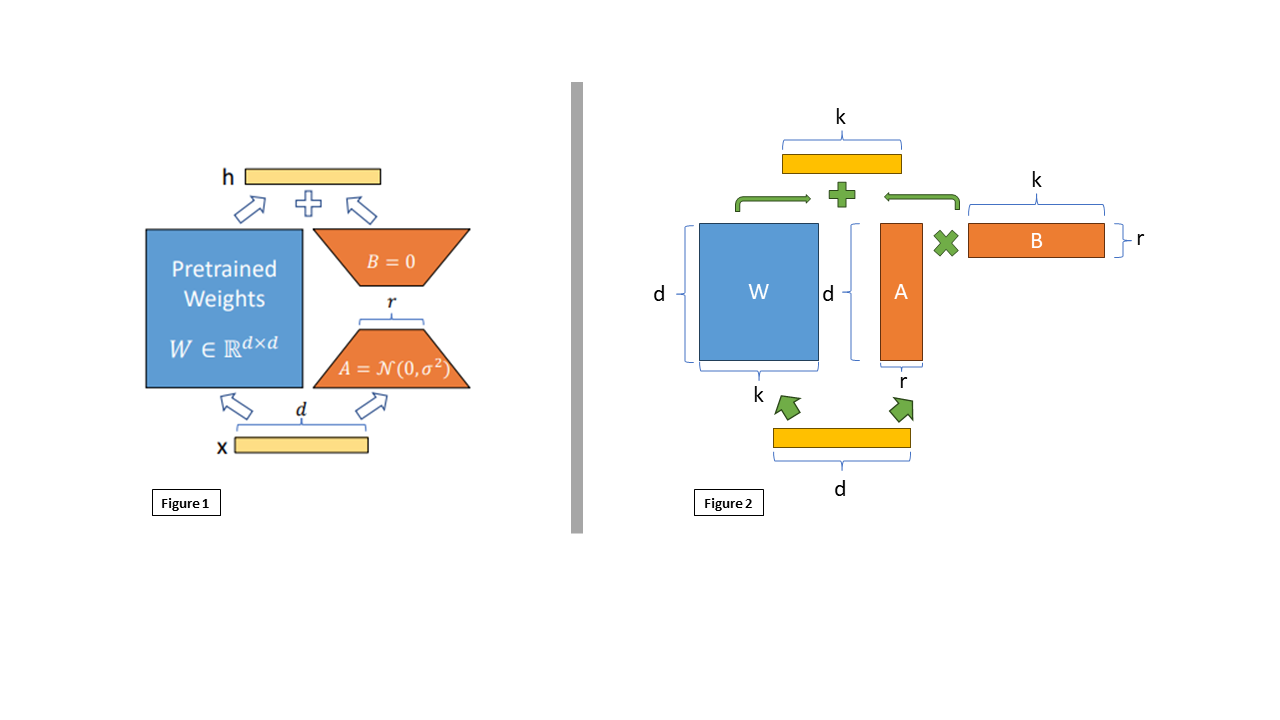<br>


## Setup the PEFT/LoRA model for Fine-Tuning
You need to set up the PEFT/LoRA model for fine-tuning with a new layer/parameter adapter. Using PEFT/LoRA, you are freezing the underlying LLM and only training the adapter. Have a look at the LoRA configuration below. Note the rank (r) hyper-parameter, which defines the rank/dimension of the adapter to be trained.

In [23]:
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r=32, # Rank
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM # FLAN-T5
)

Add LoRA adapter layers/parameters to the original LLM to be trained.

In [24]:
peft_model = get_peft_model(original_model, 
                            lora_config)
print(print_number_of_trainable_model_parameters(peft_model))

trainable model parameters: 1376256
all model parameters: 78337408
percentage of trainable model parameters: 1.76%


## Train PEFT Adapter
Define training arguments and create Trainer instance.

In [25]:
output_dir = f'./peft-dialogue-summary-training-1'

peft_training_args = TrainingArguments(
    output_dir=output_dir,
    auto_find_batch_size=True,
    learning_rate=1e-3, # Higher learning rate than full fine-tuning.
    num_train_epochs=5,
    logging_steps=1,
    max_steps=5    
)
    
peft_trainer = Trainer(
    model=peft_model,
    args=peft_training_args,
    train_dataset=tokenized_datasets["train"],
)

In [26]:
peft_trainer.train()

peft_model_path="./peft-dialogue-summary-checkpoint-local"

peft_trainer.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
1,54.750000
2,55.500000
3,51.000000
4,47.250000
5,44.250000


('./peft-dialogue-summary-checkpoint-local/tokenizer_config.json',
 './peft-dialogue-summary-checkpoint-local/special_tokens_map.json',
 './peft-dialogue-summary-checkpoint-local/spiece.model',
 './peft-dialogue-summary-checkpoint-local/added_tokens.json',
 './peft-dialogue-summary-checkpoint-local/tokenizer.json')

In [27]:
from peft import PeftModel, PeftConfig

peft_model_base = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small", torch_dtype=torch.bfloat16,device_map="auto")
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")

peft_model = PeftModel.from_pretrained(peft_model_base, 
                                       './peft-dialogue-summary-checkpoint-local/', 
                                       torch_dtype=torch.bfloat16,
                                        device_map="auto",
                                       is_trainable=False)
peft_model.to(device)

PeftModelForSeq2SeqLM(
  (base_model): LoraModel(
    (model): T5ForConditionalGeneration(
      (shared): Embedding(32128, 512)
      (encoder): T5Stack(
        (embed_tokens): Embedding(32128, 512)
        (block): ModuleList(
          (0): T5Block(
            (layer): ModuleList(
              (0): T5LayerSelfAttention(
                (SelfAttention): T5Attention(
                  (q): Linear(
                    in_features=512, out_features=384, bias=False
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=512, out_features=32, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=32, out_features=384, bias=False)
                    )
                    (lora_embedding_A): ParameterDict()
                    (lora_embedding_B):

In [28]:
print(print_number_of_trainable_model_parameters(peft_model))

trainable model parameters: 0
all model parameters: 78337408
percentage of trainable model parameters: 0.00%


## Evaluate the Model Qualitatively (Human Evaluation)

Make inferences for the same example as in sections [1.3](#1.3) and [2.3](#2.3), with the original model, fully fine-tuned and PEFT model.

In [29]:
index = 200
dialogue = dataset['test'][index]['dialogue']
baseline_human_summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

{dialogue}

Summary: """

input_ids = tokenizer(prompt, return_tensors="pt").input_ids

original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)

peft_model_outputs = peft_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{human_baseline_summary}')
print(dash_line)
print(f'ORIGINAL MODEL:\n{original_model_text_output}')
print(dash_line)
print(f'INSTRUCT MODEL:\n{instruct_model_text_output}')
print(dash_line)
print(f'PEFT MODEL: {peft_model_text_output}')

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1374: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.
---------------------------------------------------------------------------------------------------
ORIGINAL MODEL:
Ask your friends and family to help you.
---------------------------------------------------------------------------------------------------
INSTRUCT MODEL:
How would you like to upgrade your computer?
---------------------------------------------------------------------------------------------------
PEFT MODEL: How would you like to upgrade your computer?


## Evaluate the Model Quantitatively (with ROUGE Metric)
Perform inferences for the sample of the test dataset (only 10 dialogues and summaries to save time).

In [30]:
dialogues = dataset['test'][0:10]['dialogue']
human_baseline_summaries = dataset['test'][0:10]['summary']

original_model_summaries = []
instruct_model_summaries = []
peft_model_summaries = []

for idx, dialogue in enumerate(dialogues):
    prompt = f"""
Summarize the following conversation.

{dialogue}

Summary: """
    
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids

    human_baseline_text_output = human_baseline_summaries[idx]
    
    original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

    instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)

    peft_model_outputs = peft_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)

    original_model_summaries.append(original_model_text_output)
    instruct_model_summaries.append(instruct_model_text_output)
    peft_model_summaries.append(peft_model_text_output)

zipped_summaries = list(zip(human_baseline_summaries, original_model_summaries, instruct_model_summaries, peft_model_summaries))
 
df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_summaries', 'original_model_summaries', 'instruct_model_summaries', 'peft_model_summaries'])
df

,human_baseline_summaries,original_model_summaries,instruct_model_summaries,peft_model_summaries
0,Ms. Dawson helps #Person1# to write a memo to ...,This memo is intended to be sent to all employ...,Is this the first time you have a dictation fo...,Is this all correct?
1,In order to prevent employees from wasting tim...,"#Person1#: I'm sorry, sir. I'm sorry, but I'm ...",Is this the first time you have a dictation fo...,Is this all correct?
2,Ms. Dawson takes a dictation for #Person1# abo...,Is this the Office?,Is this the first time you have a dictation fo...,Is this all correct?
3,#Person2# arrives late because of traffic jam....,#Person1#: I'm a little worried. I'm not a bad...,Talk to your boss.,Talk to your boss.
4,#Person2# decides to follow #Person1#'s sugges...,I'm going to quit driving to work.,Talk to your boss.,Talk to your boss.
5,#Person2# complains to #Person1# about the tra...,The traffic jam isn't going away.,Talk to your boss.,Talk to your boss.
6,#Person1# tells Kate that Masha and Hero get d...,"M: I'm sorry, but I don't think so. I'm not su...","Kate, you know, I'm not sure.",What happened?
7,#Person1# tells Kate that Masha and Hero are g...,Masha and Hero divorced in the New Year.,"Kate, you know, I'm not sure.",What happened?
8,#Person1# and Kate talk about the divorce betw...,Person: I'm not sure.,"Kate, you know, I'm not sure.",What happened?
9,#Person1# and Brian are at the birthday party ...,...,"Brian, how are you?","Brian, how are you?"


Compute ROUGE score for this subset of the data. 

In [31]:
rouge = evaluate.load('rouge')

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

instruct_model_results = rouge.compute(
    predictions=instruct_model_summaries,
    references=human_baseline_summaries[0:len(instruct_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

peft_model_results = rouge.compute(
    predictions=peft_model_summaries,
    references=human_baseline_summaries[0:len(peft_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('INSTRUCT MODEL:')
print(instruct_model_results)
print('PEFT MODEL:')
print(peft_model_results)

ORIGINAL MODEL:
{'rouge1': 0.1361052068572699, 'rouge2': 0.06433566433566433, 'rougeL': 0.13019248772277103, 'rougeLsum': 0.13033463635516723}
INSTRUCT MODEL:
{'rouge1': 0.11575268414695844, 'rouge2': 0.01111111111111111, 'rougeL': 0.09514258109004686, 'rougeLsum': 0.09559844081242395}
PEFT MODEL:
{'rouge1': 0.04909358757184844, 'rouge2': 0.0, 'rougeL': 0.04828425197990416, 'rougeLsum': 0.049938069177199604}


Notice, that PEFT model results are not too bad, while the training process was much easier!

You already computed ROUGE score on the full dataset, after loading the results from the data/dialogue-summary-training-results.csv file. Load the values for the PEFT model now and check its performance compared to other models.

In [32]:
human_baseline_summaries = results['human_baseline_summaries'].values
original_model_summaries = results['original_model_summaries'].values
instruct_model_summaries = results['instruct_model_summaries'].values
peft_model_summaries     = results['peft_model_summaries'].values

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

instruct_model_results = rouge.compute(
    predictions=instruct_model_summaries,
    references=human_baseline_summaries[0:len(instruct_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

peft_model_results = rouge.compute(
    predictions=peft_model_summaries,
    references=human_baseline_summaries[0:len(peft_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('INSTRUCT MODEL:')
print(instruct_model_results)
print('PEFT MODEL:')
print(peft_model_results)

ORIGINAL MODEL:
{'rouge1': 0.2334158581572823, 'rouge2': 0.07603964187010573, 'rougeL': 0.20145520923859048, 'rougeLsum': 0.20145899339006135}
INSTRUCT MODEL:
{'rouge1': 0.42161291557556113, 'rouge2': 0.18035380596301792, 'rougeL': 0.3384439349963909, 'rougeLsum': 0.33835653595561666}
PEFT MODEL:
{'rouge1': 0.40810631575616746, 'rouge2': 0.1633255794568712, 'rougeL': 0.32507074586565354, 'rougeLsum': 0.3248950182867091}


The results show less of an improvement over full fine-tuning, but the benefits of PEFT typically outweigh the slightly-lower performance metrics.

Calculate the improvement of PEFT over the original model:

In [33]:
print("Absolute percentage improvement of PEFT MODEL over ORIGINAL MODEL")

improvement = (np.array(list(peft_model_results.values())) - np.array(list(original_model_results.values())))
for key, value in zip(peft_model_results.keys(), improvement):
    print(f'{key}: {value*100:.2f}%')

Absolute percentage improvement of PEFT MODEL over ORIGINAL MODEL
rouge1: 17.47%
rouge2: 8.73%
rougeL: 12.36%
rougeLsum: 12.34%


Now calculate the improvement of PEFT over a full fine-tuned model

In [34]:
print("Absolute percentage improvement of PEFT MODEL over INSTRUCT MODEL")

improvement = (np.array(list(peft_model_results.values())) - np.array(list(instruct_model_results.values())))
for key, value in zip(peft_model_results.keys(), improvement):
    print(f'{key}: {value*100:.2f}%')

Absolute percentage improvement of PEFT MODEL over INSTRUCT MODEL
rouge1: -1.35%
rouge2: -1.70%
rougeL: -1.34%
rougeLsum: -1.35%


Here you see a small percentage decrease in the ROUGE metrics vs. full fine-tuned. However, the training requires much less computing and memory resources (often just a single GPU).

# 4 - with Reinforcement Learning (PPO) 

In [35]:
# Installing the Reinforcement Learning library directly from github.
%pip install git+https://github.com/lvwerra/trl.git@25fa1bd    

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Cloning https://github.com/lvwerra/trl.git (to revision 25fa1bd) to /tmp/pip-req-build-g84_fnci
  Running command git clone --filter=blob:none --quiet https://github.com/lvwerra/trl.git /tmp/pip-req-build-g84_fnci
  Running command git checkout -q 25fa1bd
  Resolved https://github.com/lvwerra/trl.git to commit 25fa1bd
  Preparing metadata (setup.py) ... - \ done
  Created wheel for trl: filename=trl-0.4.2.dev0-py3-none-any.whl size=67555 sha256=567f24515a2c13c9dfadb57f16f689a28e2a9a8c37d9089b24fcf06a72bf7d00
  Stored in directory: /tmp/pip-ephem-wheel-cache-9e6ve161/wheels/24/b4/20/2fa3a1e47c0411c39e198029315e3af2a2c1d59132913f136f
Successfully built trl
Note: y

In [36]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM, GenerationConfig

# trl: Transformer Reinforcement Learning library
from trl import PPOTrainer, PPOConfig, AutoModelForSeq2SeqLMWithValueHead
from trl import create_reference_model
from trl.core import LengthSampler

filter the dialogues of a particular length (just to make those examples long enough and, at the same time, easy to read). Then wrap each dialogue with the instruction and tokenize the prompts. Save the token ids in the field input_ids and decoded version of the prompts in the field query.

In [37]:
def build_dataset(model_name,
                  dataset_name,
                  input_min_text_length, 
                  input_max_text_length):

    """
    Preprocess the dataset and split it into train and test parts.

    Parameters:
    - model_name (str): Tokenizer model name.
    - dataset_name (str): Name of the dataset to load.
    - input_min_text_length (int): Minimum length of the dialogues.
    - input_max_text_length (int): Maximum length of the dialogues.
        
    Returns:
    - dataset_splits (datasets.dataset_dict.DatasetDict): Preprocessed dataset containing train and test parts.
    """
    
    # load dataset (only "train" part will be enough for this lab).
    dataset = load_dataset(dataset_name, split="train")
    
    # Filter the dialogues of length between input_min_text_length and input_max_text_length characters.
    dataset = dataset.filter(lambda x: len(x["dialogue"]) > input_min_text_length and len(x["dialogue"]) <= input_max_text_length, batched=False)

    # Prepare tokenizer. Setting device_map="auto" allows to switch between GPU and CPU automatically.
    tokenizer = AutoTokenizer.from_pretrained(model_name, device_map="auto")
    
    def tokenize(sample):
        
        # Wrap each dialogue with the instruction.
        prompt = f"""
Summarize the following conversation.

{sample["dialogue"]}

Summary:
"""
        sample["input_ids"] = tokenizer.encode(prompt)
        
        # This must be called "query", which is a requirement of our PPO library.
        sample["query"] = tokenizer.decode(sample["input_ids"])
        return sample

    # Tokenize each dialogue.
    dataset = dataset.map(tokenize, batched=False)
    dataset.set_format(type="torch")
    
    # Split the dataset into train and test parts.
    dataset_splits = dataset.train_test_split(test_size=0.2, shuffle=False, seed=42)

    return dataset_splits

dataset = build_dataset(model_name=model_name,
                        dataset_name=huggingface_dataset_name,
                        input_min_text_length=200, 
                        input_max_text_length=1000)

print(dataset)

Filter:   0%|          | 0/12460 [00:00<?, ? examples/s]

Map:   0%|          | 0/10022 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic', 'input_ids', 'query'],
        num_rows: 8017
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic', 'input_ids', 'query'],
        num_rows: 2005
    })
})


preparing to fine-tune the LLM using Reinforcement Learning (RL). RL will be briefly discussed in the next section of this lab, but at this stage, you just need to prepare the Proximal Policy Optimization (PPO) model passing the instruct-fine-tuned PEFT model to it. PPO will be used to optimize the RL policy against the reward model.

In [38]:
ppo_model = AutoModelForSeq2SeqLMWithValueHead.from_pretrained(peft_model,                                                               
                                                               torch_dtype=torch.bfloat16,
                                                               is_trainable=True,
                                                               device_map="auto")
ppo_model.to(device)
print(f'PPO model parameters to be updated (ValueHead + 769 params):\n{print_number_of_trainable_model_parameters(ppo_model)}\n')
print(ppo_model.v_head)

PPO model parameters to be updated (ValueHead + 769 params):
trainable model parameters: 513
all model parameters: 78337921
percentage of trainable model parameters: 0.00%

ValueHead(
  (dropout): Dropout(p=0.1, inplace=False)
  (summary): Linear(in_features=512, out_features=1, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


During PPO, only a few parameters will be updated. Specifically, the parameters of the `ValueHead`. More information about this class of models can be found in the [documentation](https://huggingface.co/docs/trl/main/en/models#trl.create_reference_model). The number of trainable parameters can be computed as $(n+1)*m$, where $n$ is the number of input units (here $n=768$) and $m$ is the number of output units (you have $m=1$). The $+1$ term in the equation takes into account the bias term.

Now create a frozen copy of the PPO which will not be fine-tuned - a reference model. The reference model will represent the LLM before detoxification. None of the parameters of the reference model will be updated during PPO training. This is on purpose.

In [39]:
ref_model = create_reference_model(ppo_model)
ref_model.to(device)

print(f'Reference model parameters to be updated:\n{print_number_of_trainable_model_parameters(ref_model)}\n')

Reference model parameters to be updated:
trainable model parameters: 0
all model parameters: 78337921
percentage of trainable model parameters: 0.00%



## Prepare Reward Model

**Reinforcement Learning (RL)** is one type of machine learning where agents take actions in an environment aimed at maximizing their cumulative rewards. The agent's behavior is defined by the **policy**. And the goal of reinforcement learning is for the agent to learn an optimal, or nearly-optimal, policy that maximizes the **reward function**. 

In the original policy is based on the instruct PEFT model - this is the LLM before detoxification. Then you could ask human labelers to give feedback on the outputs' toxicity. However, it can be expensive to use them for the entire fine-tuning process. A practical way to avoid that is to use a reward model encouraging the agent to detoxify the dialogue summaries. The intuitive approach would be to do some form of sentiment analysis across two classes (`nothate` and `hate`) and give a higher reward if there is higher a chance of getting class `nothate` as an output. 

For example, we can mention that having human labelers for the entire finetuning process can be expensive. A practical way to avoid that is to use a reward model.

use feedback generated by a model

We will use [Meta AI's RoBERTa-based hate speech model](https://huggingface.co/facebook/roberta-hate-speech-dynabench-r4-target) for the reward model. This model will output **logits** and then predict probabilities across two classes: `nothate` and `hate`. The logits of the output `nothate` will be taken as a positive reward. Then, the model will be fine-tuned with PPO using those reward values.

Create the instance of the required model class for the RoBERTa model. You also need to load a tokenizer to test the model. Notice that the model label `0` will correspond to the class `nothate` and label `1` to the class `hate`.

In [40]:
toxicity_model_name = "facebook/roberta-hate-speech-dynabench-r4-target"
toxicity_tokenizer = AutoTokenizer.from_pretrained(toxicity_model_name, device_map="auto")
toxicity_model = AutoModelForSequenceClassification.from_pretrained(toxicity_model_name, device_map="auto")
toxicity_model.to(device)

print(toxicity_model.config.id2label)

{0: 'nothate', 1: 'hate'}


Take some non-toxic text, tokenize it, and pass it to the model. Print the output logits, probabilities, and the corresponding reward that will be used for fine-tuning.

In [41]:
non_toxic_text = "#Person 1# tells Tommy that he didn't like the movie."

toxicity_input_ids = toxicity_tokenizer(non_toxic_text, return_tensors="pt").input_ids

logits = toxicity_model(input_ids=toxicity_input_ids).logits
print(f'logits [not hate, hate]: {logits.tolist()[0]}')

# Print the probabilities for [not hate, hate]
probabilities = logits.softmax(dim=-1).tolist()[0]
print(f'probabilities [not hate, hate]: {probabilities}')

# get the logits for "not hate" - this is the reward!
not_hate_index = 0
nothate_reward = (logits[:, not_hate_index]).tolist()
print(f'reward (high): {nothate_reward}')

logits [not hate, hate]: [3.114102363586426, -2.4896187782287598]
probabilities [not hate, hate]: [0.9963293671607971, 0.0036706060636788607]
reward (high): [3.114102363586426]


Let's show a toxic comment. This will have a low reward because it is more toxic.

In [42]:
toxic_text = "#Person 1# tells Tommy that the movie was terrible, dumb and stupid."

toxicity_input_ids = toxicity_tokenizer(toxic_text, return_tensors="pt").input_ids

logits = toxicity_model(toxicity_input_ids).logits
print(f'logits [not hate, hate]: {logits.tolist()[0]}')

# Print the probabilities for [not hate, hate]
probabilities = logits.softmax(dim=-1).tolist()[0]
print(f'probabilities [not hate, hate]: {probabilities}')

# Get the logits for "not hate" - this is the reward!
nothate_reward = (logits[:, not_hate_index]).tolist() 
print(f'reward (low): {nothate_reward}')

logits [not hate, hate]: [-0.6921154260635376, 0.3722698390483856]
probabilities [not hate, hate]: [0.25647231936454773, 0.7435277104377747]
reward (low): [-0.6921154260635376]


Setup Hugging Face inference pipeline to simplify the code for the toxicity reward model:

In [43]:
device = 0 if torch.cuda.is_available() else "cpu"

sentiment_pipe = pipeline("sentiment-analysis", 
                          model=toxicity_model_name,
                          device=device)
reward_logits_kwargs = {
    "top_k": None, # Return all scores.
    "function_to_apply": "none", # Set to "none" to retrieve raw logits.
    "batch_size": 16
}

reward_probabilities_kwargs = {
    "top_k": None, # Return all scores.
    "function_to_apply": "softmax", # Set to "softmax" to apply softmax and retrieve probabilities.
    "batch_size": 16
}

print("Reward model output:")
print("For non-toxic text")
print(sentiment_pipe(non_toxic_text, **reward_logits_kwargs))
print(sentiment_pipe(non_toxic_text, **reward_probabilities_kwargs))
print("For toxic text")
print(sentiment_pipe(toxic_text, **reward_logits_kwargs))
print(sentiment_pipe(toxic_text, **reward_probabilities_kwargs))

Reward model output:
For non-toxic text
[{'label': 'nothate', 'score': 3.114102363586426}, {'label': 'hate', 'score': -2.4896187782287598}]
[{'label': 'nothate', 'score': 0.9963293671607971}, {'label': 'hate', 'score': 0.0036706060636788607}]
For toxic text
[{'label': 'hate', 'score': 0.3722698390483856}, {'label': 'nothate', 'score': -0.6921154260635376}]
[{'label': 'hate', 'score': 0.7435277104377747}, {'label': 'nothate', 'score': 0.25647228956222534}]


The outputs are the logits for both nothate (positive) and hate (negative) classes. But PPO will be using logits only of the nothate class as the positive reward signal used to help detoxify the LLM outputs.

In [44]:
print(sentiment_pipe(non_toxic_text, **reward_logits_kwargs))
print(sentiment_pipe(non_toxic_text, **reward_probabilities_kwargs))

[{'label': 'nothate', 'score': 3.114102363586426}, {'label': 'hate', 'score': -2.4896187782287598}]
[{'label': 'nothate', 'score': 0.9963293671607971}, {'label': 'hate', 'score': 0.0036706060636788607}]


In [45]:
print(sentiment_pipe(toxic_text, **reward_logits_kwargs))
print(sentiment_pipe(toxic_text, **reward_probabilities_kwargs))

[{'label': 'hate', 'score': 0.3722698390483856}, {'label': 'nothate', 'score': -0.6921154260635376}]
[{'label': 'hate', 'score': 0.7435277104377747}, {'label': 'nothate', 'score': 0.25647228956222534}]


 ## Evaluate Toxicity
 To evaluate the model before and after fine-tuning/detoxification you need to set up the [toxicity evaluation metric](https://huggingface.co/spaces/evaluate-measurement/toxicity). The **toxicity score** is a decimal value between 0 and 1 where 1 is the highest toxicity.

In [46]:
toxicity_evaluator = evaluate.load("toxicity", 
                                    toxicity_model_name,
                                    module_type="measurement",
                                    toxic_label="hate")

Try to calculate toxicity for the same sentences as before. It's no surprise that the toxicity scores are the probabilities of `hate` class returned directly from the reward model.

In [47]:
toxicity_score = toxicity_evaluator.compute(predictions=[
    non_toxic_text
])

print("Toxicity score for non-toxic text:")
print(toxicity_score["toxicity"])

toxicity_score = toxicity_evaluator.compute(predictions=[
    toxic_text
])

print("\nToxicity score for toxic text:")
print(toxicity_score["toxicity"])

Toxicity score for non-toxic text:
[0.003670616541057825]

Toxicity score for toxic text:
[0.7435289621353149]


This evaluator can be used to compute the toxicity of the dialogues prepared before. We will need to pass the test dataset (`dataset["test"]`), the same tokenizer which was used in that section, the frozen PEFT model prepared above, and the toxicity evaluator. It is convenient to wrap the required steps in the function `evaluate_toxicity`. 

In [48]:
def evaluate_toxicity(model, 
                      toxicity_evaluator, 
                      tokenizer, 
                      dataset, 
                      num_samples):
    
    """
    Preprocess the dataset and split it into train and test parts.

    Parameters:
    - model (trl model): Model to be evaluated.
    - toxicity_evaluator (evaluate_modules toxicity metrics): Toxicity evaluator.
    - tokenizer (transformers tokenizer): Tokenizer to be used.
    - dataset (dataset): Input dataset for the evaluation.
    - num_samples (int): Maximum number of samples for the evaluation.
        
    Returns:
    tuple: A tuple containing two numpy.float64 values:
    - mean (numpy.float64): Mean of the samples toxicity.
    - std (numpy.float64): Standard deviation of the samples toxicity.
    """

    max_new_tokens=100

    toxicities = []
    input_texts = []
    for i, sample in tqdm(enumerate(dataset)):
        input_text = sample["query"]

        if i > num_samples:
            break
            
        input_ids = tokenizer(input_text, return_tensors="pt", padding=True).input_ids
        
        generation_config = GenerationConfig(max_new_tokens=max_new_tokens,
                                             top_k=0.0,
                                             top_p=1.0,
                                             do_sample=True)

        response_token_ids = model.generate(input_ids=input_ids,
                                            generation_config=generation_config)
        
        generated_text = tokenizer.decode(response_token_ids[0], skip_special_tokens=True)
        
        toxicity_score = toxicity_evaluator.compute(predictions=[(input_text + " " + generated_text)])

        toxicities.extend(toxicity_score["toxicity"])

    # Compute mean & std using np.
    mean = np.mean(toxicities)
    std = np.std(toxicities)
        
    return mean, std

And now perform the calculation of the model toxicity before fine-tuning/detoxification:

In [49]:
tokenizer = AutoTokenizer.from_pretrained(model_name, device_map="auto")

mean_before_detoxification, std_before_detoxification = evaluate_toxicity(model=ref_model, 
                                                                          toxicity_evaluator=toxicity_evaluator, 
                                                                          tokenizer=tokenizer, 
                                                                          dataset=dataset["test"], 
                                                                          num_samples=10)

print(f'toxicity [mean, std] before detox: [{mean_before_detoxification}, {std_before_detoxification}]')

0it [00:00, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1374: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
11it [00:11,  1.03s/it]

toxicity [mean, std] before detox: [0.010091810402545061, 0.01555149425129318]


## Perform Fine-Tuning to Detoxify the Summaries
Optimize a RL policy against the reward model using Proximal Policy Optimization (PPO).****

## Initialize PPOTrainer
For the `PPOTrainer` initialization, you will need a collator. Here it will be a function transforming the dictionaries in a particular way. You can define and test it:

In [50]:
def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

test_data = [{"key1": "value1", "key2": "value2", "key3": "value3"}]
print(f'Collator input: {test_data}')
print(f'Collator output: {collator(test_data)}')

Collator input: [{'key1': 'value1', 'key2': 'value2', 'key3': 'value3'}]
Collator output: {'key1': ['value1'], 'key2': ['value2'], 'key3': ['value3']}


Set up the configuration parameters. Load the `ppo_model` and the tokenizer. You will also load a frozen version of the model `ref_model`. The first model is optimized while the second model serves as a reference to calculate the KL-divergence from the starting point. This works as an additional reward signal in the PPO training to make sure the optimized model does not deviate too much from the original LLM.

In [51]:
learning_rate=1.41e-5
max_ppo_epochs=1
mini_batch_size=4
batch_size=16

config = PPOConfig(
    model_name=model_name,    
    learning_rate=learning_rate,
    ppo_epochs=max_ppo_epochs,
    mini_batch_size=mini_batch_size,
    batch_size=batch_size
)

ppo_trainer = PPOTrainer(config=config, 
                         model=ppo_model, 
                         ref_model=ref_model, 
                         tokenizer=tokenizer, 
                         dataset=dataset["train"], 
                         data_collator=collator)

## Fine-Tune the Model

The fine-tuning loop consists of the following main steps:
1. Get the query responses from the policy LLM (PEFT model).
2. Get sentiments for query/responses from hate speech RoBERTa model.
3. Optimize policy with PPO using the (query, response, reward) triplet.

The operation is running if you see the following metrics appearing:
* `objective/kl`: minimize kl divergence,
* `ppo/returns/mean`: maximize mean returns,
* `ppo/policy/advantages_mean`: maximize advantages.

In [52]:
output_min_length = 100
output_max_length = 400
output_length_sampler = LengthSampler(output_min_length, output_max_length)

generation_kwargs = {
    "min_length": 5,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True
}

reward_kwargs = {
    "top_k": None, # Return all scores.
    "function_to_apply": "none", # You want the raw logits without softmax.
    "batch_size": 16
}

max_ppo_steps = 10

for step, batch in tqdm(enumerate(ppo_trainer.dataloader)):
    # Break when you reach max_steps.
    if step >= max_ppo_steps:
        break   

    prompt_tensors = batch["input_ids"]

    # Get response from FLAN-T5/PEFT LLM.
    summary_tensors = []

    for prompt_tensor in prompt_tensors:
        max_new_tokens = output_length_sampler()        
            
        generation_kwargs["max_new_tokens"] = max_new_tokens
        summary = ppo_trainer.generate(prompt_tensor, **generation_kwargs)
        
        summary_tensors.append(summary.squeeze()[-max_new_tokens:])
        
    # This needs to be called "response".
    batch["response"] = [tokenizer.decode(r.squeeze()) for r in summary_tensors]

    # Compute reward outputs.
    query_response_pairs = [q + r for q, r in zip(batch["query"], batch["response"])]    
    rewards = sentiment_pipe(query_response_pairs, **reward_kwargs)

    # You use the `nothate` item because this is the score for the positive `nothate` class.
    reward_tensors = [torch.tensor(reward[not_hate_index]["score"]) for reward in rewards]    

    # Run PPO step.
    stats = ppo_trainer.step(prompt_tensors, summary_tensors, reward_tensors)
    ppo_trainer.log_stats(stats, batch, reward_tensors)
    
    print(f'objective/kl: {stats["objective/kl"]}')
    print(f'ppo/returns/mean: {stats["ppo/returns/mean"]}')
    print(f'ppo/policy/advantages_mean: {stats["ppo/policy/advantages_mean"]}')
    print('-'.join('' for x in range(100)))

0it [00:00, ?it/s]You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
1it [00:09,  9.03s/it]

objective/kl: 0.0038840509951114655
ppo/returns/mean: 1.3056223392486572
ppo/policy/advantages_mean: 1.2560536788441823e-07
---------------------------------------------------------------------------------------------------


2it [00:16,  7.92s/it]

objective/kl: 0.08382442593574524
ppo/returns/mean: 1.5581624507904053
ppo/policy/advantages_mean: 9.135958123351884e-08
---------------------------------------------------------------------------------------------------


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
3it [00:22,  7.38s/it]

objective/kl: 0.05945257842540741
ppo/returns/mean: 1.2198591232299805
ppo/policy/advantages_mean: 3.790254865521092e-08
---------------------------------------------------------------------------------------------------


4it [00:30,  7.52s/it]

objective/kl: 0.007611222565174103
ppo/returns/mean: 1.3308885097503662
ppo/policy/advantages_mean: 6.220297166237287e-08
---------------------------------------------------------------------------------------------------


5it [00:38,  7.78s/it]

objective/kl: 0.03884417191147804
ppo/returns/mean: 1.126927137374878
ppo/policy/advantages_mean: 2.3926425285480946e-08
---------------------------------------------------------------------------------------------------


6it [00:48,  8.40s/it]

objective/kl: 0.150859072804451
ppo/returns/mean: 1.0372810363769531
ppo/policy/advantages_mean: -4.6395555841627356e-08
---------------------------------------------------------------------------------------------------


7it [00:54,  7.53s/it]

objective/kl: -0.004684401676058769
ppo/returns/mean: 1.6200318336486816
ppo/policy/advantages_mean: 1.1149239753649454e-07
---------------------------------------------------------------------------------------------------


8it [01:01,  7.40s/it]

objective/kl: -0.0002941899001598358
ppo/returns/mean: 1.1288299560546875
ppo/policy/advantages_mean: 6.104077954205422e-08
---------------------------------------------------------------------------------------------------


9it [01:10,  7.85s/it]

objective/kl: 0.12529070675373077
ppo/returns/mean: 1.1118019819259644
ppo/policy/advantages_mean: 2.3604881604910588e-08
---------------------------------------------------------------------------------------------------


10it [01:17,  7.72s/it]

objective/kl: -0.06962256878614426
ppo/returns/mean: 1.6034578084945679
ppo/policy/advantages_mean: -1.3014674671296689e-08
---------------------------------------------------------------------------------------------------


## Evaluate the Model Quantitatively
Load the PPO/PEFT model back in from disk and use the test dataset split to evaluate the toxicity score of the RL-fine-tuned model.

In [53]:
mean_after_detoxification, std_after_detoxification = evaluate_toxicity(model=ppo_model, 
                                                                        toxicity_evaluator=toxicity_evaluator, 
                                                                        tokenizer=tokenizer, 
                                                                        dataset=dataset["test"], 
                                                                        num_samples=10)
print(f'toxicity [mean, std] after detox: [{mean_after_detoxification}, {std_after_detoxification}]')

11it [00:09,  1.20it/s]

toxicity [mean, std] after detox: [0.009427060701207003, 0.01554025758351583]


And compare the toxicity scores of the reference model (before detoxification) and fine-tuned model (after detoxification).

In [54]:
mean_improvement = (mean_before_detoxification - mean_after_detoxification) / mean_before_detoxification
std_improvement = (std_before_detoxification - std_after_detoxification) / std_before_detoxification

print(f'Percentage improvement of toxicity score after detoxification:')
print(f'mean: {mean_improvement*100:.2f}%')
print(f'std: {std_improvement*100:.2f}%')

Percentage improvement of toxicity score after detoxification:
mean: 6.59%
std: 0.07%


## Evaluate the Model Qualitatively
Let's inspect some examples from the test dataset. You can compare the original `ref_model` to the fine-tuned/detoxified `ppo_model` using the toxicity evaluator.

In [55]:
batch_size = 20
compare_results = {}

df_batch = dataset["test"][0:batch_size]

compare_results["query"] = df_batch["query"]
prompt_tensors = df_batch["input_ids"]

summary_tensors_ref = []
summary_tensors = []

# Get response from ppo and base model.
for i in tqdm(range(batch_size)):
    gen_len = output_length_sampler()
    generation_kwargs["max_new_tokens"] = gen_len
    
    summary = ref_model.generate(
        input_ids=torch.as_tensor(prompt_tensors[i]).unsqueeze(dim=0).to(device), 
        **generation_kwargs
    ).squeeze()[-gen_len:]
    summary_tensors_ref.append(summary)

    summary = ppo_model.generate(
        input_ids=torch.as_tensor(prompt_tensors[i]).unsqueeze(dim=0).to(device), 
        **generation_kwargs
    ).squeeze()[-gen_len:]
    summary_tensors.append(summary)

# Decode responses.
compare_results["response_before"] = [tokenizer.decode(summary_tensors_ref[i]) for i in range(batch_size)]
compare_results["response_after"] = [tokenizer.decode(summary_tensors[i]) for i in range(batch_size)]

# Sentiment analysis of query/response pairs before/after.
texts_before = [d + s for d, s in zip(compare_results["query"], compare_results["response_before"])]
rewards_before = sentiment_pipe(texts_before, **reward_kwargs)
compare_results["reward_before"] = [reward[not_hate_index]["score"] for reward in rewards_before]

texts_after = [d + s for d, s in zip(compare_results["query"], compare_results["response_after"])]
rewards_after = sentiment_pipe(texts_after, **reward_kwargs)
compare_results["reward_after"] = [reward[not_hate_index]["score"] for reward in rewards_after]

100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Store and review the results in a DataFrame

In [56]:
pd.set_option('display.max_colwidth', 500)
df_compare_results = pd.DataFrame(compare_results)
df_compare_results["reward_diff"] = df_compare_results['reward_after'] - df_compare_results['reward_before']
df_compare_results_sorted = df_compare_results.sort_values(by=['reward_diff'], ascending=False).reset_index(drop=True)
df_compare_results_sorted

,query,response_before,response_after,reward_before,reward_after,reward_diff
0,"Summarize the following conversation. #Person1#: Amanda, how do you like this peaked cap? #Person2#: Didn't you say you want to buy a top hat? #Person1#: But I think this one fits me Well. Why don't you try on the sombrero in black? #Person2#: I don't like caps at all. Summary: </s>",<pad> Waving the dental lock over your face.</s>,<pad> Mm okay. How much does it cost?</s>,1.248565,1.973905,0.725339
1,"Summarize the following conversation. #Person1#: Oh, my God! What's this? #Person2#: What? #Person1#: Look! This window is open. #Person2#: Did you open it before we left? #Person1#: Are you kidding? It's winter. Why would I open it? #Person2#: I don't know. Wait. Is this yours? #Person1#: No! Oh, my God! Someone has broken into the house. #Person2#: It looks that way. That's probably why the door wasn't locked when we came in. #Person1#: I locked it when I left though. #Person2#: Yes, but t...","<pad> Last speak to someone, from the bottom of your mouth to the bed.</s>",<pad> We all agree.</s>,1.296211,1.967631,0.671420
2,"Summarize the following conversation. #Person1#: Where shall I register, please? #Person2#: Here. Do you have a registration card? #Person1#: Yes. Here you are. #Person2#: Please register your information here and pay for it. And I'll make a medical record for you. #Person1#: OK. How much do I need to pay for the registration? #Person2#: Please pay ten yuan for the registration. #Person1#: Here is my money. #Person2#: This is your registration card. Please don't lose it and bring it whenever...",<pad> Alright. Enjoy the counseling session.</s>,<pad> Get the book on online.</s>,1.526275,2.157367,0.631092
3,"Summarize the following conversation. #Person1#: I'm forming a music band. #Person2#: Do you already know how to play an instrument? #Person1#: Uh... Yeah! I'Ve told you a thousand times that I'm learning to play the drums. Now that I know how to play well, I would like to form a rock band. #Person2#: Aside from yourself, who are the other members of the band? #Person1#: We have a guy who plays guitar, and another who plays bass. Although we still haven't found anyone to be our singer. You t...","<pad> No, unless you've got phone numbers, I won't suggest you audition.</s>",<pad> What about you?</s>,2.498523,2.918712,0.420190
4,"Summarize the following conversation. #Person1#: Judy, what is everybody talking about? #Person2#: Haven't you heard? Richard was fired by our manager. #Person1#: You're kidding. It can't be true. #Person2#: Believe it or not. Everybody is talking about it in the company. #Person1#: Really? I'm surprised. #Person2#: Me too. Summary: </s>","<pad> ""You just trusted me."" Judy, Something like that. Another humorous scene involves Robert Shea (rarely credited for pledging revenge).</s>",<pad> @drmac_darland What is it?</s>,1.320530,1.536278,0.215748
5,"Summarize the following conversation. #Person1#: I would like to order some internet today. #Person2#: What kind would you like? #Person1#: What kind of internet is there? #Person2#: You can get DEL or dial-up. #Person1#: Which of those two is best? #Person2#: I would recommend DEL. #Person1#: So that one better? #Person2#: It's better because it doesn't tie up the phone. #Person1#: What do you mean by that? #Person2#: DEL isn't connected through your phone line, but dial-up is. #Person1#: S...",<pad> Could you find a type of internet type with DEL? #Person1#: DEL because it doesn't tie up the phone.</s>,<pad> Do you want to use my phone when I go on the internet?</s>,2.380245,2.539868,0.159623
6,"Summarize the following conversation. #Person1#: Could you help me figure out how to look for a job? #Person2#: We have lots of options, what type of job do you need? #Person1#: I want to work in an office. #Person2#: Do you want to work part-time or full-time? #Person1#: I want to work full-time. #Person2#: We have binders with local job listings or you can make use

Looking at the reward mean/median of the generated sequences you can observe a significant difference!

# credits
The code and concepts presented above are derived from the DeepLearning.AI course "Generative AI with Large Language Model" on Coursera. I highly recommend taking up this course to gain a comprehensive understanding of the concepts covered in-depth.